In [22]:
#Loading necessary packages
#pip install nltk==3.6.2 
import requests
import pandas as pd
import datetime
import time
import random
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from finvader import finvader

In [23]:
# Data
api_key = 'OTl2SM9_8xGEkqop_pj57cYyS4gjsurl'
news_url = "https://api.polygon.io/v2/reference/news"  

**Choose stock ticker & time span:**

In [24]:
#user input
ticker = input("Enter the stock ticker symbol (e.g., BA): ").strip().upper()
if not ticker:
    print("No ticker entered. Try again.")
    exit()

date_choice = input(
    "Choose the date range by typing in a corresponding number:\n"
    "1. Last day\n"
    "2. Last week\n"
    "3. Last month\n"
    "Enter your choice (1, 2, or 3): ").strip()

In [25]:
today = datetime.date.today()
if date_choice == "1":
    start_date = (today - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
elif date_choice == "2":
    start_date = (today - datetime.timedelta(days=7)).strftime("%Y-%m-%d")
elif date_choice == "3":
    start_date = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
else:
    print("Invalid choice. Defaulting to last month.")
    start_date = (today - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
end_date = today.strftime("%Y-%m-%d")
    
print(f"Start Date: {start_date}, End Date: {end_date}")

Start Date: 2024-12-13, End Date: 2025-01-12


In [26]:
def get_news(ticker, start_date, end_date, api_key, news_url, limit=100):
    """
    Fetch news for a ticker within a given date range.
    :param ticker: Stock ticker symbol.
    :param start_date: Start date (DD-MM-YYYY).
    :param end_date: End date (DD-MM-YYYY).
    :param limit: Number of articles to retrieve per request.
    :return: List of news articles.
    """
    params = {
        "ticker": ticker,
        "published_utc.gte": start_date,
        "published_utc.lte": end_date,
        "limit": limit,
        "apiKey": api_key
    }
    time.sleep(random.uniform(1, 3))  
    
    response = requests.get(news_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get("results", [])
    else:
        print(f"Failed to get news: {response.status_code} - {response.text}")
        return []

In [27]:
news = get_news(ticker, start_date, end_date, api_key, news_url)
if not news:
    print("No news found.")
    exit()

In [28]:
news_df = pd.DataFrame(news)
news_df.head()

,id,publisher,title,author,published_utc,article_url,tickers,image_url,description,keywords,insights,amp_url
0,c79d26b181fc37c24757ef31daba6e4e838ba2dd218515...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",China Has a 6th-Generation Fighter Jet. What D...,The Motley Fool,2025-01-11T12:07:00Z,https://www.fool.com/investing/2025/01/11/chin...,"[LMT, BA, BApA, NOC]",https://g.foolcdn.com/editorial/images/803120/...,China has tested two new sixth-generation figh...,"[China, fighter jets, sixth-generation, Lockhe...","[{'ticker': 'LMT', 'sentiment': 'positive', 's...",NaN
1,2890c929b5f4be48fe621e17f20237da3353af0464b9bb...,"{'name': 'Investing.com', 'homepage_url': 'htt...",Q4 Earnings Season Preview: S&P 500 Stocks Poi...,Jesse Cohen,2025-01-10T13:30:00Z,https://www.investing.com/analysis/q4-earnings...,"[AMJB, JPM, JPMpC, JPMpD, JPMpJ, JPMpK, JPMpL,...",https://i-invdn-com.investing.com/redesign/ima...,The S&P 500 is expected to report its highest ...,"[earnings season, S&P 500, earnings growth, se...","[{'ticker': 'AMJB', 'sentiment': 'positive', '...",https://m.investing.com/analysis/q4-earnings-s...
2,4eb3a22ce9545d6681a88706d0fb11242b10b89be8a552...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Why Hexcel Stock Fell in 2024,Lou Whiteman,2025-01-09T15:04:55Z,https://www.fool.com/investing/2025/01/09/why-...,"[HXL, BA, BApA]",https://g.foolcdn.com/editorial/images/803433/...,"Hexcel, a leading aerospace supplier, has face...","[Hexcel, Boeing, aerospace, composite material...","[{'ticker': 'HXL', 'sentiment': 'negative', 's...",NaN
3,ac82bc41e3f2217d02bd177078c3711f7994cb97164b53...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Here's Why Boeing Stock Slumped in 2024,Lee Samaha,2025-01-09T13:43:17Z,https://www.fool.com/investing/2025/01/09/here...,"[BA, BApA, ALK]",https://g.foolcdn.com/editorial/images/803425/...,"Boeing had a difficult year in 2024, marked by...","[Boeing, 737 MAX, 777X, Aerospace, Airline ind...","[{'ticker': 'BA', 'sentiment': 'negative', 'se...",NaN
4,b83fa3a0bbab8869a9074cb5606361ce7854d61d81d0af...,"{'name': 'GlobeNewswire Inc.', 'homepage_url':...",Satellite Manufacturing Market to surpass USD ...,N/A,2025-01-07T09:30:00Z,https://www.globenewswire.com/news-release/202...,"[BA, BApA, LMT, NOC, TSAT]",https://ml.globenewswire.com/Resource/Download...,The satellite manufacturing industry is expect...,"[satellite manufacturing, communication servic...","[{'ticker': 'BA', 'sentiment': 'positive', 'se...",NaN


In [29]:
news_df['published_utc'] = pd.to_datetime(news_df['published_utc'], errors='coerce')
news_df['combined_text'] = news_df['title'] + " " + news_df['description'].fillna("")
news_df.dropna(subset=['published_utc'], inplace=True)

**Sentiment Analysis** using combined title and description

In [30]:
#finVADER implementation
def sentiment_analysis(text):
    try:
        score = finvader(
            text,
            use_sentibignomics=True,  # Use SentiBignomics lexicon
            use_henry=True,          # Use Henry's lexicon
            indicator="compound"     # Compound sentiment score
        )
        return score
    except Exception as e:
        print(f"Error in FinVADER analysis: {e}")
        return None

In [38]:
#FinVADER sentiment analysis based on news article title 
#news_df['finvader_compound'] = news_df['title'].apply(sentiment_analysis)

In [31]:
#FinVADER sentiment analysis based on combination of article title & description

news_df['combined_text'] = news_df['title'] + " " + news_df['description'].fillna("")
news_df['combined_score'] = news_df['combined_text'].apply(sentiment_analysis)

In [39]:
def aggregate_sentiment(df):
    """Aggregating sentiment scores into daily, weekly, and monthly for easier overview."""
    df['date'] = df['published_utc'].dt.date
    daily_sentiment = df.groupby('date')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'daily_sentiment'})
    
    df['week_start'] = df['published_utc'] - pd.to_timedelta(df['published_utc'].dt.dayofweek, unit='d')
    weekly_sentiment = df.groupby('week_start')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'weekly_sentiment'})
    
    df['month'] = df['published_utc'].dt.to_period('M')
    monthly_sentiment = df.groupby('month')['combined_score'].mean().reset_index().rename(columns={'combined_score': 'monthly_sentiment'})
    
    return daily_sentiment, weekly_sentiment, monthly_sentiment


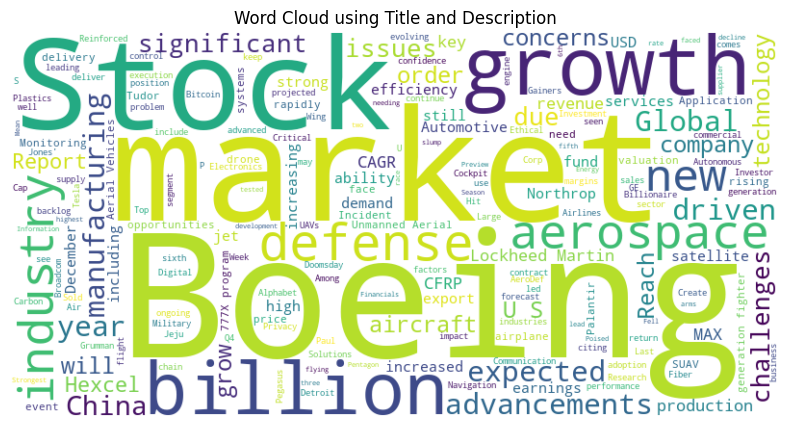

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(news_df['combined_text']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud using Title and Description")
plt.show()

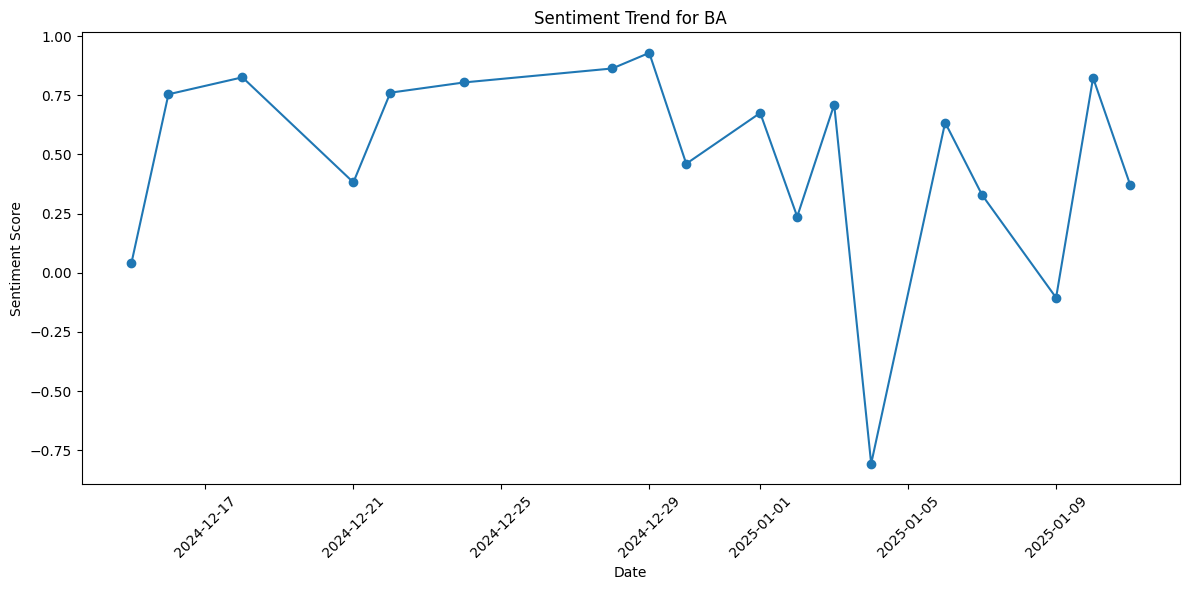

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['daily_sentiment'], marker='o')
plt.title(f"Sentiment Trend for {ticker}")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

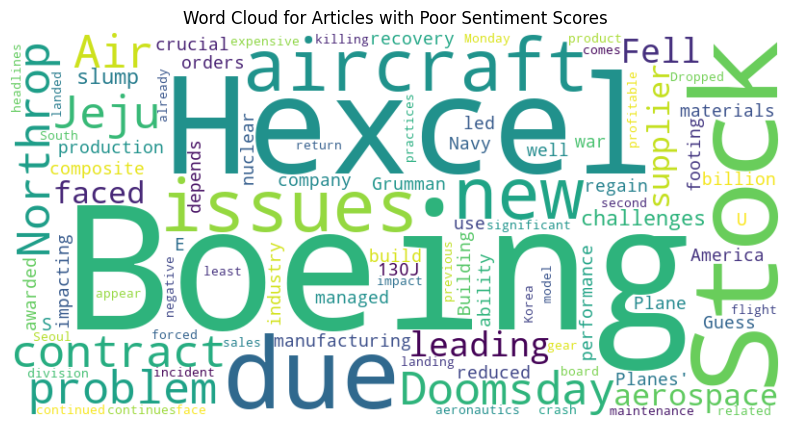

In [42]:
poor_sentiment_data = news_df[news_df['combined_score'] < 0]

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(poor_sentiment_data['combined_text'].dropna())
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Articles with Poor Sentiment Scores")
plt.show()

In [43]:
poor_sentiment_data

,id,publisher,title,author,published_utc,article_url,tickers,image_url,description,keywords,insights,amp_url,combined_text,combined_score,date,week_start,month
2,4eb3a22ce9545d6681a88706d0fb11242b10b89be8a552...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Why Hexcel Stock Fell in 2024,Lou Whiteman,2025-01-09 15:04:55+00:00,https://www.fool.com/investing/2025/01/09/why-...,"[HXL, BA, BApA]",https://g.foolcdn.com/editorial/images/803433/...,"Hexcel, a leading aerospace supplier, has face...","[Hexcel, Boeing, aerospace, composite material...","[{'ticker': 'HXL', 'sentiment': 'negative', 's...",NaN,"Why Hexcel Stock Fell in 2024 Hexcel, a leadin...",-0.3166,2025-01-09,2025-01-06 15:04:55+00:00,2025-01
6,c6546b070ab6d03df5abbfd9a45760d97e04f9b18f017f...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Guess Who's Building America's New Doomsday Pl...,Rich Smith,2025-01-04 12:07:00+00:00,https://www.fool.com/investing/2025/01/04/gues...,"[NOC, LMT, RTX, BA, BApA]",https://g.foolcdn.com/editorial/images/802675/...,The U.S. Navy awarded Northrop Grumman a $3.5 ...,"[Northrop Grumman, U.S. Navy, Doomsday Planes,...","[{'ticker': 'NOC', 'sentiment': 'neutral', 'se...",NaN,Guess Who's Building America's New Doomsday Pl...,-0.8071,2025-01-04,2024-12-30 12:07:00+00:00,2025-01
10,a79a3e8191375d9868404076fd340da3abf71f4ee2fa8c...,"{'name': 'The Motley Fool', 'homepage_url': 'h...",Why Boeing Stock Dropped on Monday,Rich Smith,2024-12-30 16:33:00+00:00,https://www.fool.com/investing/2024/12/30/why-...,"[BA, BApA]",https://g.foolcdn.com/editorial/images/802402/...,Boeing's 737-800 model continues to face issue...,"[Boeing, 737-800, Jeju Air, landing gear]","[{'ticker': 'BA', 'sentiment': 'negative', 'se...",NaN,Why Boeing Stock Dropped on Monday Boeing's 73...,-0.7811,2024-12-30,2024-12-30 16:33:00+00:00,2024-12
